In [1]:
import os
import pandas as pd
import numpy as np
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
func = "../Function/"
sys.path.append(func)
from py_helper_functions import *


import patsy
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

***Import data***

In [2]:
data = pd.read_csv('../Data/cs_bisnode_panel.csv')

***Drop variables with too many NAs (> 250000)***

In [3]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

COGS                 269572
amort                  8040
curr_assets             131
curr_liab               131
extra_exp             18529
extra_inc             18529
extra_profit_loss     17203
finished_prod        270344
fixed_assets            131
inc_bef_tax            7437
intang_assets           140
inventories             131
liq_assets              131
material_exp           8040
net_dom_sales        269572
net_exp_sales        269572
personnel_exp          8040
profit_loss_year       9884
sales                  7437
share_eq                131
subscribed_cap          131
tang_assets            1470
wages                269846
D                    287829
founded_year          56457
exit_year            248970
ceo_count             56427
foreign               56427
female                56427
birth_year           111818
inoffice_days         56427
gender                56427
origin                56427
nace_main              1038
ind2                   1038
ind                 

In [4]:
del data['COGS']
del data['finished_prod']
del data['net_dom_sales']
del data['net_exp_sales']
del data['wages']
del data['D']

In [5]:
data.head(2).transpose()

,0,1
comp_id,1.00103e+06,1.00103e+06
begin,2005-01-01,2006-01-01
end,2005-12-31,2006-12-31
amort,692.593,603.704
curr_assets,7266.67,13122.2
curr_liab,7574.07,12211.1
extra_exp,0,0
extra_inc,0,0
extra_profit_loss,0,0
fixed_assets,1229.63,725.926


***Label & Feature engineering***

*Whether a company is alive depends on its income before tax.*

*Generate a ratio called profit margin, profit margin = profit or loss/sales. The profit or loss variable is considered to be profit if it is greater than 0, and loss if it is less than 0.*

*I define what "fast growth" is, fast growth is a company that is alive and the profit margin at least 7% after 2 year.*

In [6]:
data = data.set_index(['year','comp_id']).unstack(fill_value ='toReplace').stack().reset_index()
data = data.replace('toReplace',np.nan)

In [7]:
data['status_alive'] = (data['inc_bef_tax'] > 0 & (False == data['inc_bef_tax'].isna())).astype(int)

In [8]:
data['profit_margin_ratio'] = data['profit_loss_year']/data['sales']

In [9]:
data['profit_margin_ratio'].describe()

count    2.653170e+05
mean              NaN
std               NaN
min              -inf
25%     -4.528262e-01
50%      0.000000e+00
75%      3.590641e-02
max               inf
Name: profit_margin_ratio, dtype: float64

In [10]:
data['fast_growth'] = ((data['status_alive'] == 1) & (data.groupby('comp_id')['profit_margin_ratio'].shift(-2) > 0.07)).astype(int)

In [11]:
data['fast_growth'].describe()

count    556944.000000
mean          0.037745
std           0.190580
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fast_growth, dtype: float64

*The task said I need to start with the panel for 2010-2015.*

In [12]:
data = data.loc[lambda x: x["year"].isin(["2010", 
                                          "2011", 
                                          "2012", 
                                          "2013", 
                                          "2014", 
                                          "2015"
                                                ])]

In [13]:
pd.set_option('display.max_columns',None)
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,nace_main,ind2,ind,urban_m,labor_avg,status_alive,profit_margin_ratio,fast_growth
count,278472.000000,2.784720e+05,1.634890e+05,1.675490e+05,1.675490e+05,1.638550e+05,1.638550e+05,1.638510e+05,1.675490e+05,1.638640e+05,1.675490e+05,1.675490e+05,1.675490e+05,1.634890e+05,1.634890e+05,1.675390e+05,1.638640e+05,1.675490e+05,1.675490e+05,1.675490e+05,167606.000000,167606.000000,167606.000000,149197.000000,16958.000000,149203.000000,149203.000000,149203.000000,124385.000000,149203.000000,167547.000000,167547.000000,162640.000000,167606.000000,114260.000000,278472.000000,1.595380e+05,278472.000000
mean,2012.500000,1.546307e+11,1.719720e+04,1.940143e+05,1.577606e+05,1.602941e+03,3.455814e+03,1.858043e+03,2.720322e+05,1.752997e+04,9.770384e+03,5.724628e+04,3.845158e+04,3.339718e+05,8.423318e+04,4.544525e+03,4.662059e+05,1.981477e+05,7.290441e+04,2.054890e+05,0.007804,343.337291,0.112687,2003.619423,2014.922868,1.255618,0.110948,0.261350,1965.863693,2881.623659,4897.088841,48.743970,2.706911,2.069055,0.969446,0.283917,NaN,0.040895
std,1.707828,1.385256e+11,2.084372e+05,1.806004e+06,1.752801e+06,8.162772e+04,2.064169e+05,1.959890e+05,8.027344e+06,5.579899e+05,7.250462e+05,6.607869e+05,5.822441e+05,2.888134e+06,6.943279e+05,3.667464e+05,3.789100e+06,4.070342e+06,2.091473e+06,2.571886e+06,0.087995,68.768099,0.316211,7.091723,1.327867,0.518682,0.303227,0.409229,11.652605,1748.134896,1227.779618,12.345946,0.503574,0.850078,4.693914,0.450898,NaN,0.198046
min,2010.000000,1.001034e+06,-5.780000e+04,-4.829259e+04,-2.277778e+04,-1.335852e+05,-2.744074e+05,-6.181263e+06,-7.340741e+03,-4.194870e+07,-5.370370e+02,-2.607407e+03,-1.303333e+05,-1.097800e+06,-1.633667e+05,-4.194870e+07,-2.553889e+05,-4.210445e+07,-1.481481e+04,-1.089630e+04,0.000000,0.000000,0.000000,1951.000000,1997.000000,1.000000,0.000000,0.000000,1920.000000,1.000000,111.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-inf,0.000000
25%,2011.000000,2.871344e+10,0.000000e+00,1.855556e+03,1.688889e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.825926e+03,0.000000e+00,0.000000e+00,2.888889e+02,2.192593e+03,2.185185e+02,-3.674074e+03,3.092593e+03,-6.555556e+03,1.851852e+03,0.000000e+00,0.000000,364.000000,0.000000,1998.000000,2014.000000,1.000000,0.000000,0.000000,1957.000000,1617.000000,3320.000000,33.000000,2.000000,1.000000,0.090278,0.000000,-5.875278e-01,0.000000
50%,2012.500000,1.159657e+11,5.518519e+02,8.555556e+03,1.026667e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.503704e+03,0.000000e+00,0.000000e+00,1.703704e+02,1.711111e+03,1.953704e+04,7.029629e+03,0.000000e+00,2.697037e+04,2.511111e+03,2.222222e+03,2.118519e+03,0.000000,364.000000,0.000000,2005.000000,2015.000000,1.000000,0.000000,0.000000,1967.000000,2497.000000,5610.000000,56.000000,3.000000,2.000000,0.234848,0.000000,-4.318037e-03,0.000000
75%,2014.000000,2.609081e+11,3.118519e+03,3.207407e+04,3.982963e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.984074e+04,3.159259e+03,0.000000e+00,4.777778e+03,8.103704e+03,7.672593e+04,2.371852e+04,1.844444e+03,1.060620e+05,2.316667e+04,1.111111e+04,2.684445e+04,0.000000,364.000000,0.000000,2010.000000,2016.000000,1.000000,0.000000,0.500000,1975.000000,3527.000000,5610.000000,56.000000,3.000000,3.000000,0.548611,1.000000,3.619520e-02,0.000000
max,2015.000000,4.641209e+11,2.799496e+07,1.411015e+08,3.264051e+08,1.704172e+07,7.233078e+07,7.233078e+07,2.696748e+09,7.921782e+07,1.594445e+08,4.158996e+07,9.125862e+07,1.031133e+08,6.146913e+07,7.911574e+07,1.110294e+08,6.982296e+08,6.918000e+08,4.511007e+08,1.000000,365.000000,1.000000,2015.000000,2017.000000,15.000000,1.000000,1.000000,2016.000000,10983.000000,9609.000000,96.0000

***Generate variables, handle outliers and missing values in variables***

In [14]:
data = data.assign(
    flag_asset_problem = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0),
    flag_liability_problem = np.where(data['curr_liab'] < 0, 1, 0),
    )

In [15]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

begin                   110866
end                     110866
amort                   114983
curr_assets             110923
curr_liab               110923
extra_exp               114617
extra_inc               114617
extra_profit_loss       114621
fixed_assets            110923
inc_bef_tax             114608
intang_assets           110923
inventories             110923
liq_assets              110923
material_exp            114983
personnel_exp           114983
profit_loss_year        110933
sales                   114608
share_eq                110923
subscribed_cap          110923
tang_assets             110923
balsheet_flag           110866
balsheet_length         110866
balsheet_notfullyear    110866
founded_year            129275
exit_year               261514
ceo_count               129269
foreign                 129269
female                  129269
birth_year              154087
inoffice_days           129269
gender                  129269
origin                  129269
nace_mai

*None of the variables related to sales, assets, or liabilities should have negative values, so I replace all values less than 0 with 0. In addition, all missing values are also replaced with 0.*

In [16]:
data['sales'] =  np.where(data['sales'].isna(), 1, data['sales'])
data['sales'] =  np.where(data['sales'] < 0, 1, data['sales'])

In [17]:
data = data.assign(
    curr_assets = np.where(data['curr_assets'] < 0, 0, data['curr_assets']),
    curr_liab = np.where(data['curr_liab'] < 0, 0, data['curr_liab']),
    liq_assets = np.where(data['liq_assets'] < 0, 0, data['liq_assets']),
    intang_assets = np.where(data['intang_assets'] < 0, 0, data['intang_assets']),
    fixed_assets = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])
    )

In [18]:
data = data.assign(
    curr_assets = np.where(data['curr_assets'].isna(), 0, data['curr_assets']),
    curr_liab = np.where(data['curr_liab'].isna(), 0, data['curr_liab']),
    liq_assets = np.where(data['liq_assets'].isna(), 0, data['liq_assets']),
    intang_assets = np.where(data['intang_assets'].isna(), 0, data['intang_assets']),
    fixed_assets = np.where(data['fixed_assets'].isna(), 0, data['fixed_assets']),
    tang_assets = np.where(data['tang_assets'].isna(), 0, data['tang_assets'])
    )

In [19]:
data = data.assign(
    current_ratio = data['curr_assets']/data['curr_liab'],
    quick_ratio = data['liq_assets']/data['curr_liab']
    )

data['current_ratio'] = np.where(data['current_ratio'].isna(), 1, data['current_ratio'])
data['quick_ratio'] = np.where(data['quick_ratio'].isna(), 1, data['quick_ratio'])

In [20]:
data['current_ratio'].describe()

count    2.784720e+05
mean              inf
std               NaN
min      0.000000e+00
25%      8.785233e-01
50%      1.000000e+00
75%      1.652019e+00
max               inf
Name: current_ratio, dtype: float64

In [21]:
data['quick_ratio'].describe()

count    2.784720e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.118334e-01
50%      1.000000e+00
75%      1.000000e+00
max               inf
Name: quick_ratio, dtype: float64

*Both current ratio and quick ratio are important indicators to measure the short-term financial risk of a company. It is generally believed that the current ratio should be above 2:1 and the quick ratio should be above 1:1. When the current ratio is greater than or equal to 10, this ratio has actually been very large, I will all use 10 instead. If the quick ratio is greater than or equal to 5, all of them will be replaced by 5.*

In [22]:
data = data.assign(
    current_ratio = np.where(data['current_ratio'] >= 10, 10, data['current_ratio']),
    quick_ratio = np.where(data['quick_ratio'] >= 5, 5, data['quick_ratio'])
    )

In [23]:
data['inc_bef_tax'] = np.where(data['inc_bef_tax'].isna(), 0, data['inc_bef_tax'])

data = data.assign(
    ln_inc_bef_tax = np.where(data['inc_bef_tax'] > 0 , np.log(data['inc_bef_tax']), 0), 
    inc_bef_tax_mil= data['inc_bef_tax']/1000000,
    inc_bef_tax_mil_log = np.where(data['inc_bef_tax'] > 0, np.log(data['inc_bef_tax']/1000000), 0)
  )

In [24]:
data = data.assign(
    d1_inc_bef_tax_mil_log = data['inc_bef_tax_mil_log'] - data.groupby('comp_id')['inc_bef_tax_mil_log'].shift(1),
    age1 = np.where(data['year'] - data['founded_year'] < 0, 0, data['year'] - data['founded_year'])
  )

data['age'] = np.where(data['age1'].isna(), data['age1'].mean(), data['age1'])
data['new_firm'] = np.where(data['age'] <= 1, 1, 0)
data['d1_inc_bef_tax_mil_log'] = np.where(data['new_firm'] == 1 , 0, data['d1_inc_bef_tax_mil_log'])
del data['age1']

In [25]:
data['flag_low_d1_inc_bef_tax_mil_log'] = np.where(data['d1_inc_bef_tax_mil_log'] < -2, 1, 0)
data['flag_high_d1_inc_bef_tax_mil_log'] = np.where(data['d1_inc_bef_tax_mil_log'] > 2, 1, 0)
data['d1_inc_bef_tax_mil_log_mod'] = np.where(data['d1_inc_bef_tax_mil_log'] < -2, -2, np.where(data['d1_inc_bef_tax_mil_log'] > 2, 2, data['d1_inc_bef_tax_mil_log']))
data['d1_inc_bef_tax_mil_log_mod_sq'] = data['d1_inc_bef_tax_mil_log_mod']**2

In [26]:
data = data.assign(
    age2 = data['age']**2,
    m_region_loc = data['region_m'].astype("category"),
    inc_bef_tax_mil_log_sq = data['inc_bef_tax_mil_log']**2,
    total_assets =  data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
    )

In [27]:
data = data.assign(
    labor_avg_mod = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg']),
    flag_miss_labor_avg = (data['labor_avg'].isna()).astype(int),
    profit_loss_year_mod = np.where(data['profit_loss_year'].isna(), data['profit_loss_year'].mean(), data['profit_loss_year']),
    share_eq_mod = np.where(data['share_eq'].isna(), data['share_eq'].mean(), data['share_eq']),
    subscribed_cap_mod = np.where(data['subscribed_cap'].isna(), data['subscribed_cap'].mean(), data['subscribed_cap']),
    material_exp_mod = np.where(data['material_exp'].isna(), data['material_exp'].mean(), data['material_exp']),
    personnel_exp_mod = np.where(data['personnel_exp'].isna(), data['personnel_exp'].mean(), data['personnel_exp']),
    inventories_mod = np.where(data['inventories'].isna(), data['inventories'].mean(), data['inventories']),
    extra_exp = np.where(data['extra_exp'].isna(), 0, data['extra_exp']),
    extra_inc = np.where(data['extra_inc'].isna(), 0, data['extra_inc']),
    extra_profit_loss = np.where(data['extra_profit_loss'].isna(), 0, data['extra_profit_loss'])
)

del data['labor_avg']
del data['profit_loss_year']
del data['share_eq']
del data['subscribed_cap']
del data['material_exp']
del data['personnel_exp']
del data['inventories']

*Variable 'ind2' is the NACE industry code (2 digit).*

*Change some industry category codes in the same way with the case shown in class.*

In [28]:
data['ind2_cat'] = data['ind2'].copy()
data['ind2_cat'] = np.where(data['ind2'] > 56,60,data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2'] < 26,20,data['ind2_cat'])
data['ind2_cat'] = np.where((data['ind2'] < 55)&(data['ind2'] > 35),40,data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2'] == 31,30,data['ind2_cat'])
data['ind2_cat'] = np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [29]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       390
26.0      8073
27.0      4956
28.0     13984
29.0      2390
30.0      1398
32.0       935
33.0     13109
35.0         5
40.0      1572
55.0     19973
56.0     98772
60.0      1990
99.0    110925
Name: comp_id, dtype: int64

In [30]:
data['f_urban_m'] = data['urban_m'].astype("category")
data['f_ind2_cat'] = data['ind2_cat'].astype("category")
data['f_fast_growth'] = data['fast_growth'].astype("category")
data['f_fast_growth'] = data['f_fast_growth'].cat.rename_categories(['no_fast_growth', 'fast_growth'])

In [31]:
data['ceo_count'].value_counts()

1.0     115666
2.0      29786
3.0       3095
4.0        537
5.0         86
6.0         22
7.0          3
8.0          3
11.0         2
15.0         1
14.0         1
13.0         1
Name: ceo_count, dtype: int64

In [32]:
data = data.assign(
    flag_low_ceo_count = (data['ceo_count'] < 2).astype(int),
    flag_high_ceo_count = (data['ceo_count'] > 4).astype(int),
    flag_miss_ceo_count = (data['ceo_count'].isna()).astype(int)
    )

data['ceo_count'] = np.where(data['ceo_count'].isna(), 1, data['ceo_count'])

In [33]:
data['inoffice_days'].describe()

count    149203.000000
mean       2881.623659
std        1748.134896
min           1.000000
25%        1617.000000
50%        2497.000000
75%        3527.000000
max       10983.000000
Name: inoffice_days, dtype: float64

In [34]:
data = data.assign(
    flag_low_ceo_inoffice_days = (data['inoffice_days'] < 1800).astype(int),
    flag_high_ceo_inoffice_days = (data['inoffice_days'] > 3600).astype(int),
    flag_miss_ceo_inoffice_days = (data['inoffice_days'].isna()).astype(int)
    )

In [35]:
data['ceo_age'] = data['year'] - data['birth_year']

data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 30).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 70).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int)
    )

data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])

*Look at cross section. Design sample for the task, choose year == 2012.*

In [36]:
data = data.query('year == 2012 & status_alive == 1')

In [37]:
data['inc_bef_tax_mil'].describe()

count    12521.000000
mean         0.063700
std          0.857443
min          0.000004
25%          0.000785
50%          0.003067
75%          0.013696
max         77.992592
Name: inc_bef_tax_mil, dtype: float64

*Limit the size of the company to below 20 million euros and above 100 euros*

In [38]:
data = data.query('inc_bef_tax_mil <= 20 & inc_bef_tax_mil >= 0.0001')

In [39]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,intang_assets,liq_assets,sales,tang_assets,balsheet_flag,balsheet_length,balsheet_notfullyear,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,nace_main,ind2,ind,urban_m,status_alive,profit_margin_ratio,fast_growth,flag_asset_problem,flag_liability_problem,current_ratio,quick_ratio,ln_inc_bef_tax,inc_bef_tax_mil,inc_bef_tax_mil_log,d1_inc_bef_tax_mil_log,age,new_firm,flag_low_d1_inc_bef_tax_mil_log,flag_high_d1_inc_bef_tax_mil_log,d1_inc_bef_tax_mil_log_mod,d1_inc_bef_tax_mil_log_mod_sq,age2,inc_bef_tax_mil_log_sq,total_assets,labor_avg_mod,flag_miss_labor_avg,profit_loss_year_mod,share_eq_mod,subscribed_cap_mod,material_exp_mod,personnel_exp_mod,inventories_mod,ind2_cat,flag_low_ceo_count,flag_high_ceo_count,flag_miss_ceo_count,flag_low_ceo_inoffice_days,flag_high_ceo_inoffice_days,flag_miss_ceo_inoffice_days,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age
count,11991.0,1.199100e+04,1.195900e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,11991.000000,11991.000000,11991.000000,10945.000000,692.000000,11991.000000,10946.000000,10946.000000,9387.000000,10946.000000,11987.000000,11987.000000,11565.000000,11991.000000,11991.0,1.197800e+04,11991.00000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,1.199100e+04,11991.000000,11991.000000,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,1.199100e+04,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,2012.0,1.538024e+11,2.662492e+04,3.263613e+05,2.576762e+05,1.656755e+03,4.703539e+03,3.040917e+03,3.966114e+05,5.572984e+04,8.835212e+03,6.797428e+04,7.824057e+05,3.432278e+05,0.006338,356.778584,0.048286,2002.077752,2015.119942,1.288216,0.107123,0.226862,1964.706401,3273.546422,4526.527405,45.021106,2.553740,2.089150,1.0,NaN,0.24410,0.000417,0.000417,3.049215,1.207671,8.349254,0.055730,-5.466256,-1.357121,9.838534,0.105746,0.272955,0.051288,-0.433537,1.734306,140.955553,33.908900,7.318079e+05,1.252134,0.178050,3.796204e+04,3.242025e+05,9.292102e+04,5.416674e+05,1.378023e+05,9.440625e+04,44.781670,0.664665,0.000917,0.087149,0.144358,0.274122,0.087149,47.195618,0.030523,0.012426,0.217163
std,0.0,1.381784e+11,2.211073e+05,2.189280e+06,3.546604e+06,3.383216e+04,1.262420e+05,1.298112e+05,5.270891e+06,3.851118e+05,1.311655e+05,8.470490e+05,4.642315e+06,4.783061e+06,0.079363,43.004584,0.214379,6.950041,1.470917,0.549162,0.296344,0.381647,11.219377,1734.843625,1354.693882,13.624954,0.559025,0.840871,0.0,NaN,0.42957,0.020417,0.020417,3.220491,1.658555,2.007306,0.385112,2.007306,2.928083,6.645486,0.307525,0.445496,0.220595,1.243576,1.747625,149.532580,20.330179,6.431059e+06,5.060799,0.382571,3.140899e+05,2.800940e+06,1.246475e+06,3.429885e+06,8.600343e+05,7.950085e+05,13.262992,0.472127,0.030275,0.282065,0.351467,0.446089,0.282065,9.928318,0.172028,0.110782,0.412332
min,2012.0,1.002029e+06,-3.333333e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.740741e+02,-2.211578e+06,0.000000e+00,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1980.000000,1997.000000,1.000000,0.000000,0.000000,1920.000000,35.000000,143.000000,1.000000,1.000000,1.000000,1.0,-inf,0.00000,0.000000,0.000000,0.000000,0.000000,4.605170,0.000100,-9.210340,-9.210340,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000048,0.000000e+00,0.083333,0.000000,-3.012222e+04,-3.950964e+07,-3.037037e+02,-5.592593e+02,-2.259259e+02,-2.607407e+03,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000
25%,2012.0,2.810872e+10,1.740741e+02,6.

***Simple linear regressions***

In [40]:
ols_s = smf.ols('fast_growth ~ inc_bef_tax_mil_log + inc_bef_tax_mil_log_sq', data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     49.91
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           2.59e-22
Time:                        11:15:52   Log-Likelihood:                -6832.2
No. Observations:               11991   AIC:                         1.367e+04
Df Residuals:                   11988   BIC:                         1.369e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

***Plots***

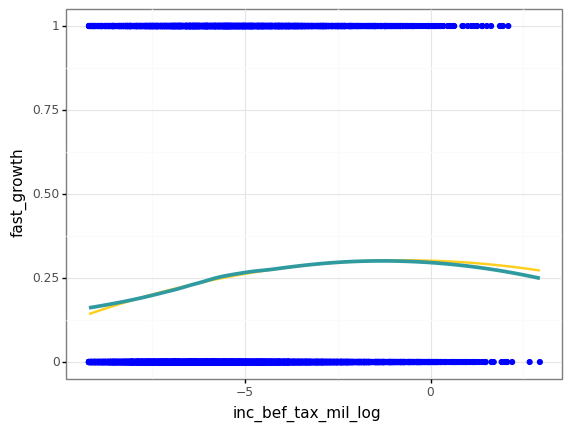

<ggplot: (8794906742384)>

In [41]:
ggplot(data, aes(x = "inc_bef_tax_mil_log", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color=color[3], se = False) + geom_smooth(
    method = "loess", color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="inc_bef_tax_mil_log", y="fast_growth"
) + theme_bw()

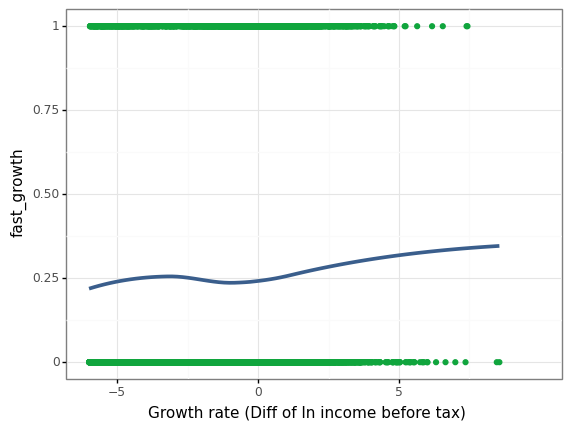

<ggplot: (8794921940830)>

In [42]:
ggplot(data, aes(x = 'd1_inc_bef_tax_mil_log', y = 'fast_growth')) + geom_point(
    color=color[1]) + geom_smooth(
    method = 'loess', color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln income before tax)', y='fast_growth') + scale_x_continuous(
    limits=(-6, 10), breaks = seq(-5, 10, by = 5)
) + theme_bw()

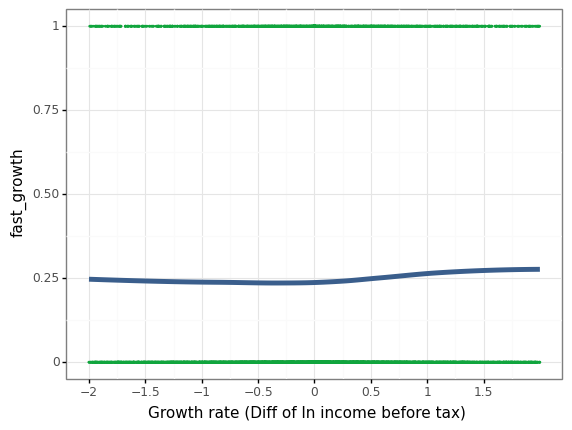

<ggplot: (8794675760550)>

In [43]:
ggplot(data, aes(x = 'd1_inc_bef_tax_mil_log', y = 'fast_growth')) + geom_point(
    size = 0.1, color = color[1]) + geom_smooth(
    method = 'loess', color = color[0], se = False, size=2, span=0.9) + labs(
    x='Growth rate (Diff of ln income before tax)', y='fast_growth') + scale_x_continuous(
    limits=(-2, 2), breaks = seq(-2, 2, by = 0.5)
) + theme_bw()

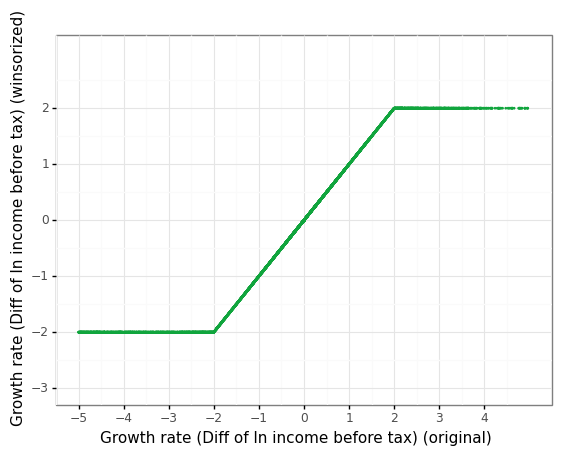

<ggplot: (8794667029619)>

In [44]:
ggplot(data, aes(x = 'd1_inc_bef_tax_mil_log', y = 'd1_inc_bef_tax_mil_log_mod')) + geom_point(
    size = 0.1, color = color[1]) + labs(
    x='Growth rate (Diff of ln income before tax) (original)', y='Growth rate (Diff of ln income before tax) (winsorized)'
) + scale_x_continuous(limits=(-5, 5), breaks = seq(-5, 5, by = 1)
) + scale_y_continuous(limits=(-3, 3), breaks = seq(-3, 3, by = 1)
) + theme_bw()

***Export .csv file***

In [45]:
data.to_csv('../Output/bisnode_firms_clean.csv', index=False)

***Import data***

In [46]:
data = pd.read_csv('../Output/bisnode_firms_clean.csv')

***Define variable sets***

In [47]:
pd.set_option('display.max_rows',None)
data.head(2).transpose()

,0,1
year,2012,2012
comp_id,1.00203e+06,1.01189e+06
begin,2012-01-01,2012-01-01
end,2012-12-31,2012-12-31
amort,14929.6,36625.9
curr_assets,203885,160167
curr_liab,120444,18911.1
extra_exp,0,0
extra_inc,0,0
extra_profit_loss,0,0


***Define variable sets***

In [48]:
basic = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
         "intang_assets", "inventories_mod", "liq_assets", "material_exp_mod", "personnel_exp_mod",
         "profit_loss_year_mod", "sales", "share_eq_mod", "subscribed_cap_mod"]
ratio = ["current_ratio", "quick_ratio"]
flag_problem = ["flag_asset_problem", "flag_liability_problem"]
d1_inc_bef_tax_related =  ["d1_inc_bef_tax_mil_log_mod", "d1_inc_bef_tax_mil_log_mod_sq",
                           "flag_low_d1_inc_bef_tax_mil_log", "flag_high_d1_inc_bef_tax_mil_log"]
ceo_related = ["ceo_age", "flag_low_ceo_inoffice_days", "flag_high_ceo_inoffice_days", "flag_miss_ceo_inoffice_days",
               'ceo_count', "flag_low_ceo_count", "flag_high_ceo_count", "flag_miss_ceo_count",  "flag_high_ceo_age", 
               "flag_low_ceo_age", "flag_miss_ceo_age", "labor_avg_mod", "flag_miss_labor_avg"]

*Creat dummy columns from category variables*

In [49]:
ind2_cat_dummy = patsy.dmatrix("0 + C(f_ind2_cat)",data, return_type = "dataframe")
ind2_cat_dummy = ind2_cat_dummy.drop(['C(f_ind2_cat)[26.0]'], axis = 1)

*Define X1, X2, X3, and rfvars.*

*I generated some interaction variables and added X3.*

*The dependent variable y is the binary variable "fast growth" that we care about.*

In [50]:
X1_vars = data[["inc_bef_tax_mil_log", "inc_bef_tax_mil_log_sq", "profit_loss_year_mod", "age", "age2", "new_firm"]]
X1 = pd.concat([X1_vars, ind2_cat_dummy], axis = 1)

X2 = pd.concat([data[["sales", "share_eq_mod", "subscribed_cap_mod"] + d1_inc_bef_tax_related + ceo_related], X1], axis = 1)

data['interaction_var1'] = data['f_ind2_cat']*data['age']
data['interaction_var2'] = data['f_ind2_cat']*data['total_assets']
data['interaction_var3'] = data['f_ind2_cat']*data['profit_loss_year_mod']
data['interaction_var4'] = data['f_ind2_cat']*data['current_ratio']
data['interaction_var5'] = data['f_ind2_cat']*data['quick_ratio']

interaction_var = ["interaction_var1", "interaction_var2", "interaction_var3",
                   "interaction_var4", "interaction_var5"]

X3 = pd.concat([data[["extra_exp", "extra_inc", "extra_profit_loss"] + ratio + flag_problem + interaction_var], X2], axis = 1)

In [51]:
rf_vars  = pd.concat([data[["inc_bef_tax_mil", "d1_inc_bef_tax_mil_log"] + basic + ceo_related]], axis = 1)

In [52]:
y = data['fast_growth']

*Define helper functions*

In [53]:
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

***Simple linear regression model***

In [54]:
OLS_model1 = LinearRegression().fit(X1, y)
regression_results(y, OLS_model1.predict(X1))

explained_variance:  0.0204
r2:  0.0204
MAE:  0.3615
MSE:  0.1807
RMSE:  0.4251


In [55]:
coef_matrix(X1, OLS_model1)

,variable,coefficient
0,inc_bef_tax_mil_log,-9.501022e-03
1,inc_bef_tax_mil_log_sq,-2.407958e-03
2,profit_loss_year_mod,9.813725e-09
3,age,2.857595e-03
4,age2,-1.114380e-04
5,new_firm,1.116794e-02
6,C(f_ind2_cat)[20.0],1.339354e-01
7,C(f_ind2_cat)[27.0],2.394057e-02
8,C(f_ind2_cat)[28.0],3.909767e-02
9,C(f_ind2_cat)[29.0],2.637817e-02


In [56]:
OLS_model2 = LinearRegression().fit(X2, y)
regression_results(y, OLS_model2.predict(X2))

explained_variance:  0.0337
r2:  0.0337
MAE:  0.3575
MSE:  0.1783
RMSE:  0.4223


In [57]:
coef_matrix(X2, OLS_model2)

,variable,coefficient
0,sales,-4.926499e-09
1,share_eq_mod,7.401597e-09
2,subscribed_cap_mod,-1.591441e-09
3,d1_inc_bef_tax_mil_log_mod,2.920553e-03
4,d1_inc_bef_tax_mil_log_mod_sq,7.672256e-03
5,flag_low_d1_inc_bef_tax_mil_log,-1.567002e-02
6,flag_high_d1_inc_bef_tax_mil_log,1.372318e-04
7,ceo_age,3.287820e-04
8,flag_low_ceo_inoffice_days,-5.226010e-02
9,flag_high_ceo_inoffice_days,-3.766204e-03


In [58]:
OLS_model3 = LinearRegression().fit(X3, y)
regression_results(y, OLS_model3.predict(X3))

explained_variance:  0.0457
r2:  0.0457
MAE:  0.3532
MSE:  0.1761
RMSE:  0.4196


In [59]:
coef_matrix(X3, OLS_model3)

,variable,coefficient
0,extra_exp,-1.130154e-05
1,extra_inc,1.121251e-05
2,extra_profit_loss,-1.131321e-05
3,current_ratio,1.738090e-02
4,quick_ratio,8.216701e-03
5,flag_asset_problem,-1.204544e-02
6,flag_liability_problem,-9.918742e-02
7,interaction_var1,3.406698e-04
8,interaction_var2,-1.405497e-10
9,interaction_var3,4.129689e-10


***Logistic models***

In [60]:
GLM_model1 = LogisticRegression(solver = "newton-cg",max_iter = 1000, penalty = "none").fit(X1, y)
regression_results(y, GLM_model1.predict(X1))

explained_variance:  0.0
r2:  -0.3229
MAE:  0.2441
MSE:  0.2441
RMSE:  0.4941


In [61]:
coef_matrix(X1, GLM_model1)

,variable,coefficient
0,inc_bef_tax_mil_log,-7.182861e-02
1,inc_bef_tax_mil_log_sq,-1.537203e-02
2,profit_loss_year_mod,6.110958e-08
3,age,1.609769e-02
4,age2,-6.243415e-04
5,new_firm,6.136167e-02
6,C(f_ind2_cat)[20.0],6.230525e-01
7,C(f_ind2_cat)[27.0],1.265328e-01
8,C(f_ind2_cat)[28.0],2.036121e-01
9,C(f_ind2_cat)[29.0],1.416247e-01


In [62]:
mx1 = sm.Logit(y,sm.add_constant(X1)).fit().get_margeff()
mx1.summary()

Optimization terminated successfully.
         Current function value: 0.545551
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
inc_bef_tax_mil_log       -0.0130      0.009     -1.516      0.129      -0.030       0.004
inc_bef_tax_mil_log_sq    -0.0028      0.001     -3.353      0.001      -0.004      -0.001
profit_loss_year_mod    1.105e-08   1.35e-08      0.818      0.413   -1.54e-08    3.75e-08
age                        0.0029      0.003      1.050      0.294      -0.003       0.008
age2                      -0.0001      0.000     -0.986      0.324      -0.000       0.000
new_firm                   0.0111      0.017      0.642      0.521      -0.023       0.045
C(f_ind2_cat)[20.0]        0.1177      0.067      1.750      0.080      -0.014       0.250
C(f_ind2_cat)[27.0]        0.0235      0.023      1.003      0.316      -0.022       0.070
C(f_ind2_cat)[28.0]        0.0374      0.018      2.072      0.038       0.002       0.073
C(f_ind2_cat)[29.0]        0.0263      0.030      0.884      0.377      -0.032       0.085
C(f_ind2_cat)[30.0]        0.0392      0.040      0.983      0.326      -0.039       0.117
C(f_ind2_cat)[32.0]        0.0166      0.045      0.369      0.712      -0.072       0.105
C(f_ind2_cat)[33.0]        0.0597      0.018      3.270      0.001       0.024       0.095
C(f_ind2_cat)[40.0]        0.0180      0.040      0.452      0.651      -0.060       0.096
C(f_ind2_cat)[55.0]        0.1088      0.018      6.012      0.000       0.073       0.144
C(f_ind2_cat)[56.0]       -0.0239      0.016     -1.447      0.148      -0.056       0.008
C(f_ind2_cat)[60.0]        0.0480      0.036      1.344      0.179      -0.022       0.118
C(f_ind2_cat)[99.0]        0.0124      0.209      0.059      0.953      -0.398       0.423
==========================================================================================
"""

In [63]:
GLM_model2 = LogisticRegression(solver = "newton-cg",max_iter = 1000, penalty = "none").fit(X2, y)
regression_results(y, GLM_model2.predict(X2))

explained_variance:  -0.0135
r2:  -0.3211
MAE:  0.2438
MSE:  0.2438
RMSE:  0.4937


In [64]:
coef_matrix(X2, GLM_model2)

,variable,coefficient
0,sales,-8.477918e-08
1,share_eq_mod,1.516806e-07
2,subscribed_cap_mod,-1.002587e-07
3,d1_inc_bef_tax_mil_log_mod,1.049996e-02
4,d1_inc_bef_tax_mil_log_mod_sq,4.325792e-02
5,flag_low_d1_inc_bef_tax_mil_log,-9.905878e-02
6,flag_high_d1_inc_bef_tax_mil_log,-2.705500e-02
7,ceo_age,1.787825e-03
8,flag_low_ceo_inoffice_days,-3.107079e-01
9,flag_high_ceo_inoffice_days,-3.734407e-02


In [65]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()

         Current function value: 0.536573
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
====================================================================================================
                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
sales                            -1.507e-08        nan        nan        nan         nan         nan
share_eq_mod                      2.694e-08        nan        nan        nan         nan         nan
subscribed_cap_mod               -1.774e-08      0.008  -2.11e-06      1.000      -0.016       0.016
d1_inc_bef_tax_mil_log_mod           0.0018        nan        nan        nan         nan         nan
d1_inc_bef_tax_mil_log_mod_sq        0.0077   3.29e+04   2.33e-07      1.000   -6.46e+04    6.46e+04
flag_low_d1_inc_bef_tax_mil_log     -0.0178   8.73e+04  -2.03e-07      1.000   -1.71e+05    1.71e+05
flag_high_d1_inc_bef_tax_mil_log    -0.0047   4.75e+04  -9.83e-08      1.000   -9.31e+04    9.31e+04
ceo_age                              0.0003    672.392   4.73e-07      1.000   -1317.864    1317.865
flag_low_ceo_inoffice_days          -0.0553        nan        nan        nan         nan         nan
flag_high_ceo_inoffice_days         -0.0066        nan        nan        nan         nan         nan
flag_miss_ceo_inoffice_days          0.0294        nan        nan        nan         nan         nan
ceo_count                            0.0331        nan        nan        nan         nan         nan
flag_low_ceo_count                   0.0526        nan        nan        nan         nan         nan
flag_high_ceo_count                 -3.4289        nan        nan        nan         nan         nan
flag_miss_ceo_count                  0.0294        nan        nan        nan         nan         nan
flag_high_ceo_age                    0.0142        nan        nan        nan         nan         nan
flag_low_ceo_age                    -0.0360        nan        nan        nan         nan         nan
flag_miss_ceo_age                   -0.0212        nan        nan        nan         nan         nan
labor_avg_mod                       -0.0121        nan        nan        nan         nan         nan
flag_miss_labor_avg                  0.0811        nan        nan        nan         nan         nan
inc_bef_tax_mil_log                  0.0306        nan        nan        nan         nan         nan
inc_bef_tax_mil_log_sq               0.0006        nan        nan        nan         nan         nan
profit_loss_year_mod              5.656e-09        nan        nan        nan         nan         nan
age                                  0.0005        nan        nan        nan         nan         nan
age2                             -1.617e-05        nan        nan        nan         nan         nan
new_firm                             0.0190        nan        nan        nan         nan         nan
C(f_ind2_cat)[20.0]                  0.1187        nan        nan        nan         nan         nan
C(f_ind2_cat)[27.0]                  0.0314        nan        nan        nan         nan         nan
C(f_ind2_cat)[28.0]                  0.0362        nan        nan        nan         nan         nan
C(f_ind2_cat)[29.0]                  0.0628        nan        nan        nan         nan         nan
C(f_ind2_cat)[30.0]                  0.0491        nan        nan        nan         nan         nan
C(f_ind2_cat)[32.0]                  0.0150        nan        nan        nan         nan         nan
C(f_ind2_cat)[33.0]                  0.0490        nan        nan        nan         nan         nan
C(f_ind2_cat)[40.0]                  0.0211        nan        nan        nan         nan         nan
C(f_ind2_cat)[55.0]      

In [66]:
GLM_model3 = LogisticRegression(solver = "newton-cg",max_iter = 1000, penalty = "none").fit(X3, y)
regression_results(y, GLM_model3.predict(X3))

explained_variance:  -0.0122
r2:  -0.3139
MAE:  0.2424
MSE:  0.2424
RMSE:  0.4924


In [67]:
coef_matrix(X3, GLM_model3)

,variable,coefficient
0,extra_exp,-9.781119e-05
1,extra_inc,9.542660e-05
2,extra_profit_loss,-9.700825e-05
3,current_ratio,1.074547e-01
4,quick_ratio,4.448086e-02
5,flag_asset_problem,-1.454634e-04
6,flag_liability_problem,-3.959381e-04
7,interaction_var1,1.074334e-03
8,interaction_var2,-1.902756e-09
9,interaction_var3,5.032400e-09


In [68]:
mx3 = sm.Logit(y,sm.add_constant(X3)).fit().get_margeff()
mx3.summary()

         Current function value: 0.529947
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
====================================================================================================
                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
extra_exp                         -1.74e-05        nan        nan        nan         nan         nan
extra_inc                         1.707e-05        nan        nan        nan         nan         nan
extra_profit_loss                -1.735e-05        nan        nan        nan         nan         nan
current_ratio                        0.0164   3.65e+04   4.48e-07      1.000   -7.15e+04    7.15e+04
quick_ratio                         -0.0008   1.21e+04  -6.57e-08      1.000   -2.36e+04    2.36e+04
flag_asset_problem                  -0.0129   2.52e+06  -5.13e-09      1.000   -4.94e+06    4.94e+06
flag_liability_problem              -0.0864        nan        nan        nan         nan         nan
interaction_var1                     0.0003        nan        nan        nan         nan         nan
interaction_var2                 -3.508e-10      0.000  -2.13e-06      1.000      -0.000       0.000
interaction_var3                  1.535e-09      0.002   9.54e-07      1.000      -0.003       0.003
interaction_var4                    -0.0004   1106.030  -3.78e-07      1.000   -2167.779    2167.778
interaction_var5                     0.0005   1776.669   2.62e-07      1.000   -3482.206    3482.207
sales                             -2.66e-08      0.019  -1.38e-06      1.000      -0.038       0.038
share_eq_mod                      3.858e-08      0.021   1.88e-06      1.000      -0.040       0.040
subscribed_cap_mod               -1.544e-09      0.003  -6.17e-07      1.000      -0.005       0.005
d1_inc_bef_tax_mil_log_mod           0.0004        nan        nan        nan         nan         nan
d1_inc_bef_tax_mil_log_mod_sq        0.0086        nan        nan        nan         nan         nan
flag_low_d1_inc_bef_tax_mil_log     -0.0197        nan        nan        nan         nan         nan
flag_high_d1_inc_bef_tax_mil_log    -0.0065        nan        nan        nan         nan         nan
ceo_age                              0.0002        nan        nan        nan         nan         nan
flag_low_ceo_inoffice_days          -0.0503        nan        nan        nan         nan         nan
flag_high_ceo_inoffice_days         -0.0090        nan        nan        nan         nan         nan
flag_miss_ceo_inoffice_days          0.0268   1.35e+14   1.98e-16      1.000   -2.64e+14    2.64e+14
ceo_count                            0.0333        nan        nan        nan         nan         nan
flag_low_ceo_count                   0.0510        nan        nan        nan         nan         nan
flag_high_ceo_count                 -3.5027        nan        nan        nan         nan         nan
flag_miss_ceo_count                  0.0268   1.35e+14   1.98e-16      1.000   -2.64e+14    2.64e+14
flag_high_ceo_age                    0.0058        nan        nan        nan         nan         nan
flag_low_ceo_age                    -0.0397        nan        nan        nan         nan         nan
flag_miss_ceo_age                   -0.0196        nan        nan        nan         nan         nan
labor_avg_mod                       -0.0076        nan        nan        nan         nan         nan
flag_miss_labor_avg                  0.0610        nan        nan        nan         nan         nan
inc_bef_tax_mil_log                  0.0290        nan        nan        nan         nan         nan
inc_bef_tax_mil_log_sq               0.0003        nan        nan        nan         nan         nan
profit_loss_year_mod     

***Separate train and holdout data***

In [69]:
index_train, index_holdout = train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [70]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('fast_growth')
print(data.iloc[index_train]['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['fast_growth'].value_counts(normalize=True))

Total
0    0.7559
1    0.2441
Name: fast_growth, dtype: float64
fast_growth
0    0.756593
1    0.243407
Name: fast_growth, dtype: float64
Holdout
0    0.753128
1    0.246872
Name: fast_growth, dtype: float64


***Predict probabilities***

In [71]:
k = KFold(n_splits = 5, shuffle = True, random_state = 42)

***Train logit models***

In [72]:
C_value_logit = [1e20]

logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)

    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

***No loss function***

In [73]:
CV_AUC_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)

    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [74]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])
    nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [75]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']
logit_summary1.to_csv("../Output/logit_model_summary.csv")
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,18.0,0.426313,0.580188
X2,38.0,0.423716,0.608406
X3,50.0,0.445841,0.524414


*Look at cross-validated performance, when there is no loss function, among the three logit models X1, X2, and X3, I choose X2 because it has the smallest CV RMSE. After pick my favorite model, predict probabilities.*

In [76]:
best_model = logit_models['X2']
best_model_X_holdout = X2.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

0.423

*If you want to check the whole array of predicted probability, u can use the code like:*
    
*total_list1 = np.array(logit_predicted_probabilities_holdout)*

*np.set_printoptions(threshold=np.inf)*

*print(total_list1)*

In [77]:
thresholds = seq(0.05, 0.8, by = 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [78]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

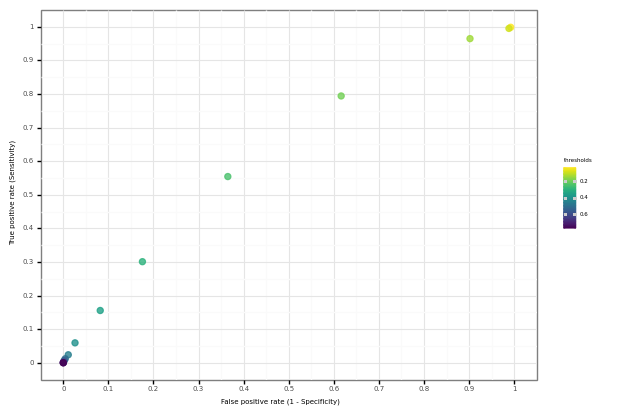

<ggplot: (8794885563661)>

In [79]:
ROC_1_X2 = ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)

ggsave(plot = ROC_1_X2, filename="ROC_1_X2.png", path = "../Output/")
ROC_1_X2

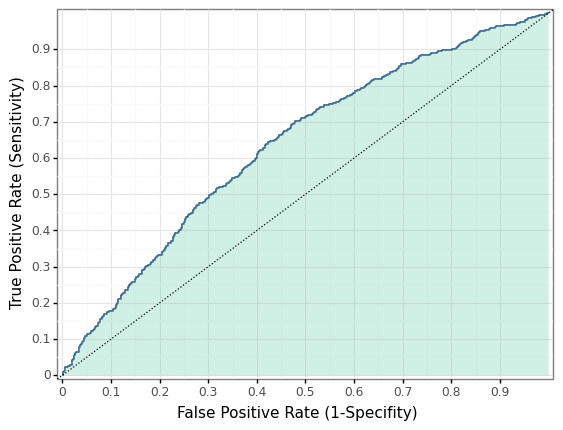

<ggplot: (8794885400826)>

In [80]:
ROC_2_X2 = create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)
ggsave(plot = ROC_2_X2, filename="ROC_2_X2.png", path = "../Output/")
ROC_2_X2

***Confusion table***

In [81]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no fast_growth): ',counts[0])
print(values[1],' (fast_growth): ',counts[1])

0  (no fast_growth):  2383
1  (fast_growth):  15


***Confusion matrix***

In [82]:
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm1

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1798,8
Actual fast_growth,585,7


In [83]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm1b

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1798,8
Actual fast_growth,585,7


In [84]:
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.241

In [85]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm2

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1089,717
Actual fast_growth,239,353


***Plot the calibration curve for logit model X1, X2, X3***

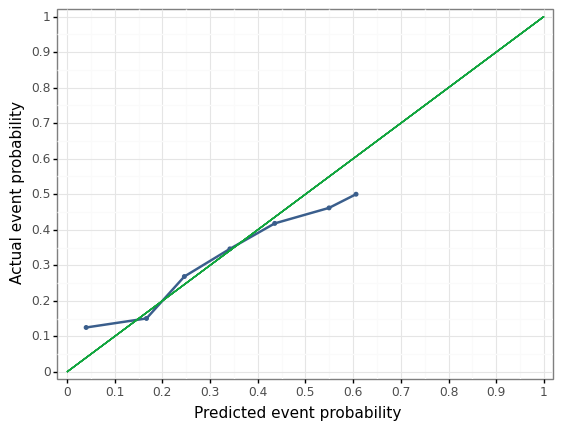

<ggplot: (8794676078484)>

In [86]:
holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
Predict_Plot_X2 = create_calibration_plot(holdout, file_name = "Estimated vs actual event probabilities",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)
ggsave(plot = Predict_Plot_X2, filename="Predict_Plot_X2.png", path = "../Output/")
Predict_Plot_X2

In [87]:
X1_model = logit_models['X1']
X1_model_X_holdout = X1.iloc[index_holdout]

logit_predicted_probabilities_holdout_X1 = X1_model.predict_proba(X1_model_X_holdout)[:,1]
X1_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout_X1))
round(X1_rmse_holdout, 3)

0.425

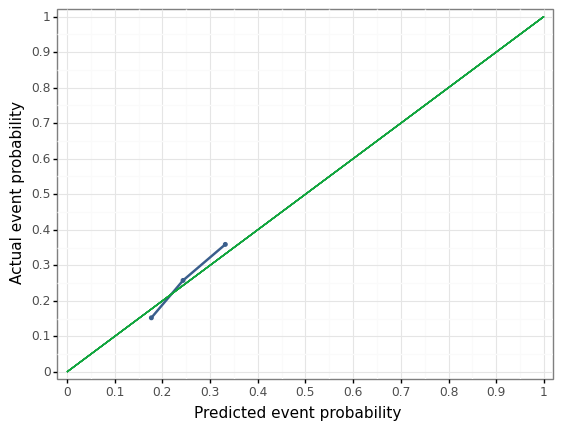

<ggplot: (8794668450533)>

In [88]:
holdout = pd.concat([X1_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout_X1
Predict_Plot_X1 = create_calibration_plot(holdout, file_name = "Estimated vs actual event probabilities",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)
ggsave(plot = Predict_Plot_X1, filename="Predict_Plot_X1.png", path = "../Output/")
Predict_Plot_X1

In [89]:
X3_model = logit_models['X3']
X3_model_X_holdout = X3.iloc[index_holdout]

logit_predicted_probabilities_holdout_X3 = X3_model.predict_proba(X3_model_X_holdout)[:,1]
X3_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout_X3))
round(X3_rmse_holdout, 3)

0.426

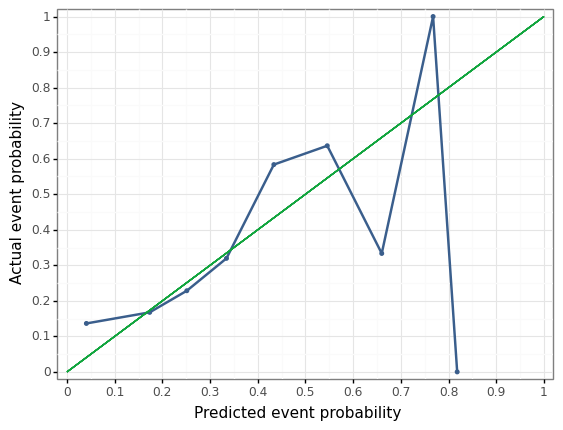

<ggplot: (8794921941932)>

In [90]:
holdout = pd.concat([X3_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout_X3
Predict_Plot_X3 = create_calibration_plot(holdout, file_name = "Estimated vs actual event probabilities",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)
ggsave(plot = Predict_Plot_X3, filename="Predict_Plot_X3.png", path = "../Output/")
Predict_Plot_X3

***With loss function***

*Define the loss function:*

*Loss function = FN, FP*

*FN=15*

*If the model predicts fast growth in business and the firm does not achieve it (a false negative), the bank loses all 15,000 euros (since the risk of investment failure is relatively high).*

*FP=5*

*If the company is not predicted to grow fast and the bank refuses to invest, but the company in fact achieves fast growth (false positive), the bank loses a €5,000 profit opportunity.*

In [91]:
FN = 15
FP = 5
cost = FN/FP

In [92]:
prevelance = y_train.sum()/len(y_train)

In [93]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss =[]
    if model_name != 'LASSO':
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index,:]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(logit_models[model_name], X_fold, fold, c_index)
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(list(zip(
            np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       thresholds)), key=lambda i: i[0], reverse=True)[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold+1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': thresholds
    })
    
    fold5_all_coords[model_name] = all_coords

In [94]:
logit_summary2 = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
logit_summary2['Threshold for Fold5'] = fold5_threshold.values()
logit_summary2['Avg expected loss'] = expected_loss_cv.values()
logit_summary2['Expected loss for Fold5'] = fold5_expected_loss.values()
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.230698,0.221428,3.245063,3.143900
1,X2,0.237906,0.246214,3.105888,3.005735
2,X3,0.390834,0.437162,3.507238,3.459333


***Look for the optimal classification threshold***

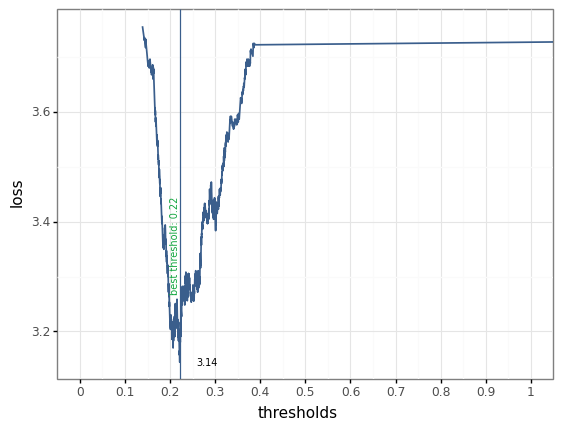

<ggplot: (8794677045592)>

In [95]:
model_to_plot = 'X1'
Optimal_threshold_X1 = create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])
ggsave(plot = Optimal_threshold_X1, filename="Optimal_threshold_X1.png", path = "../Output/")
Optimal_threshold_X1

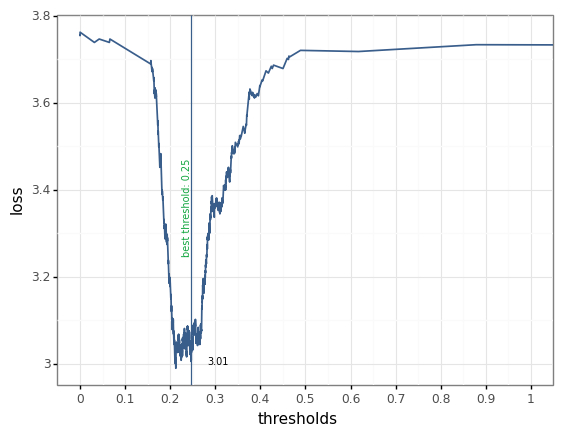

<ggplot: (8794684957221)>

In [96]:
model_to_plot = 'X2'
Optimal_threshold_X2 = create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])
ggsave(plot = Optimal_threshold_X2, filename="Optimal_threshold_X2.png", path = "../Output/")
Optimal_threshold_X2

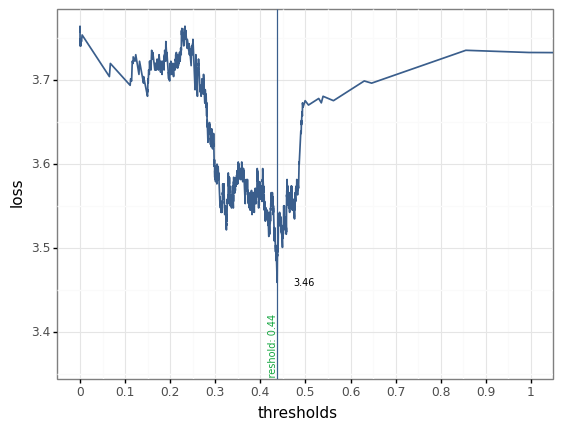

<ggplot: (8794677321930)>

In [97]:
model_to_plot = 'X3'
Optimal_threshold_X3 = create_loss_plot(fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot], fold5_expected_loss[model_to_plot])
ggsave(plot = Optimal_threshold_X3, filename="Optimal_threshold_X3.png", path = "../Output/")
Optimal_threshold_X3

In [98]:
best_logit_optimal_treshold = best_thresholds_cv["X2"]

holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

2.934

***Confusion matrix***

In [99]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1068,738
Actual fast_growth,223,369


In [100]:
best_logit_optimal_treshold_X3 = best_thresholds_cv["X3"]

holdout_treshold = np.where(logit_predicted_probabilities_holdout < best_logit_optimal_treshold_X3, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

3.582

In [101]:
cm_object_X3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cmX3 = pd.DataFrame(cm_object3, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cmX3.to_csv("../Output/confusion_matrix_of_model_X3.csv")
cmX3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1068,738
Actual fast_growth,223,369


***Random forest model***

<Figure size 432x288 with 0 Axes>

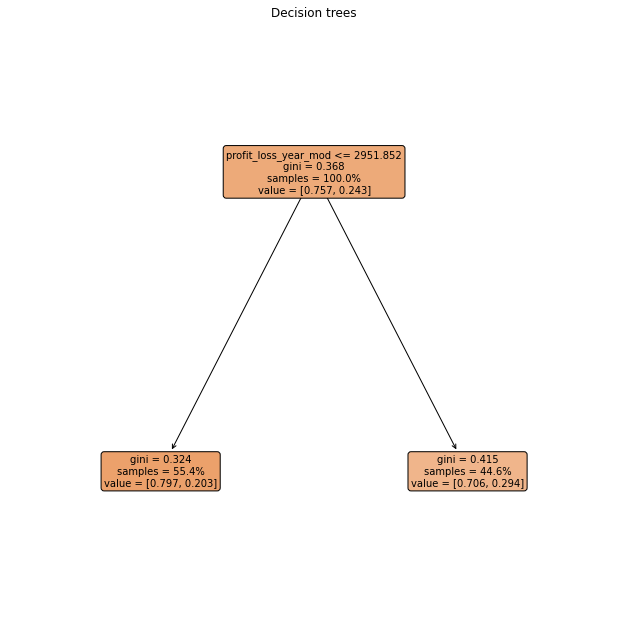

In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

rfvars_train = rf_vars.iloc[index_train]
rfvars_holdout = rf_vars.iloc[index_holdout]

data_for_graph = rfvars_train[['inc_bef_tax_mil','profit_loss_year_mod','ceo_age']]
rf_for_graph = DecisionTreeClassifier(ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41).fit(
    data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11,11))
plot_tree(rf_for_graph, 
          feature_names = data_for_graph.columns, filled=True, rounded=True, proportion=True, fontsize = 10)
plt.title("Decision trees")
plt.show()

In [103]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [104]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [105]:
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.759514,0.688421,0.411449
1,5,16,0.758159,0.688403,0.411381
2,6,11,0.758784,0.687007,0.411729
3,6,16,0.760244,0.688179,0.411326
4,7,11,0.757742,0.686165,0.411909
5,7,16,0.759410,0.685316,0.411900


In [106]:
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 16}

In [107]:
prob_forest_best_results = prob_forest_cv_results[(prob_forest_cv_results.max_features == best_mtry) & 
                      (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [108]:
CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p

In [109]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]
    
    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]
    
    prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
    expected_loss.append(curr_exp_loss)
    
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [110]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame({
    'false_pos': false_pos_rate*sum(y_fold == 0),
    'true_pos': true_pos_rate*sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

In [111]:
expected_loss_cv['rf_p'] = np.mean(expected_loss)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds)

In [112]:
rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_threshold, 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(curr_exp_loss, 3)]})

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.411,0.688,0.293,0.291,2.634,2.607


***Look for the optimal classification threshold***

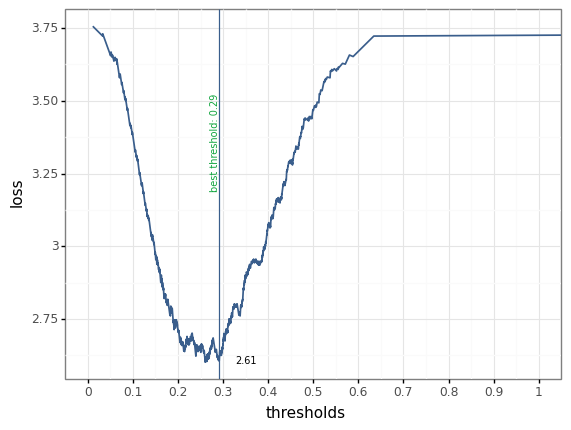

<ggplot: (8794667736769)>

In [113]:
Optimal_threshold_rf = create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)
ggsave(plot = Optimal_threshold_rf, filename="Optimal_threshold_rf.png", path = "../Output/")
Optimal_threshold_rf

*ROC curve based on random forest model*

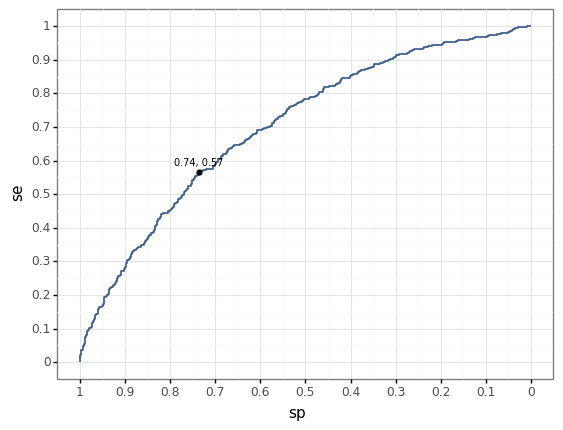

<ggplot: (8794921942694)>

In [114]:
ROC_rf = create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)
ggsave(plot = ROC_rf, filename="ROC_rf.png", path = "../Output/")
ROC_rf

In [115]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.414

In [116]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.679

In [117]:
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

2.773

***Confusion matrix***

In [118]:
cm_object4 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm4 = pd.DataFrame(cm_object4, 
    index=['Actul no fast_growth', 'Actual fast_growth'], 
    columns=['Predicted no fast_growth', 'Predicted fast_growth'])
cm4.to_csv("../Output/confusion_matrix_of_best_model.csv")
cm4

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,1256,550
Actual fast_growth,260,332


***Final results***

In [119]:
nvars['rf_p'] = len(rf_vars.columns)

summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

summary_results.to_csv("../Output/models_results_summary.csv")
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,18,0.426313,0.580188,0.230698,3.245063
1,X2,38,0.423716,0.608406,0.237906,3.105888
2,X3,50,0.445841,0.524414,0.390834,3.507238
3,rf_p,30,0.411326,0.688179,0.292647,2.634201


***Plot the calibration curve for random forest model***

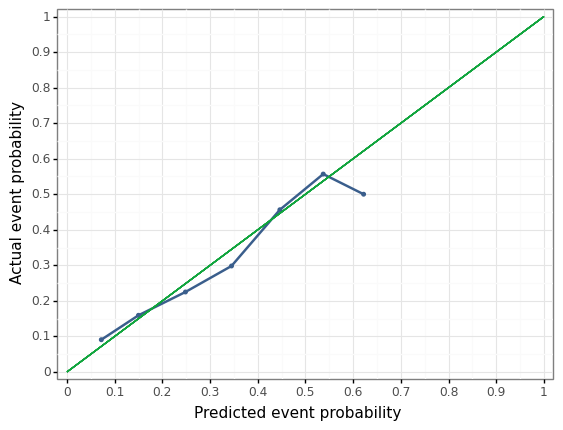

<ggplot: (8794767954167)>

In [120]:
holdout = pd.concat([rfvars_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = rf_predicted_probabilities_holdout
Predict_Plot_rf = create_calibration_plot(holdout, file_name = "Estimated vs actual event probabilities",\
                        prob_var='best_logit_no_loss_pred', actual_var='fast_growth',\
                        y_lab="Actual event probability", n_bins=10, breaks=None)
ggsave(plot = Predict_Plot_rf, filename="Predict_Plot_rf.png", path = "../Output/")
Predict_Plot_rf